In [2]:
#!pip install --proxy=http://proxy.pccw.com:8080 tslearn

In [1]:
#!pip install --proxy=http://proxy.pccw.com:8080 plotly 

# Member Life Cycle Analysis

## Setting Up

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from random import sample

In [2]:
from sklearn.neighbors import KNeighborsClassifier  
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, KNeighborsTimeSeries

import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler


In [3]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.figure_factory as ff

In [88]:
from IPython.core.display import HTML 


In [4]:
import warnings
warnings.filterwarnings('ignore')

## Import Data Set

In [5]:
LC2=pd.read_excel('Life_Cycle2.xlsx',header=1,index_col=0)
LC2.head(5)

,2015Qtr1,2015Qtr2,2015Qtr3,2015Qtr4,2015Sum,2016Qtr1,2016Qtr2,2016Qtr3,2016Qtr4,2016Sum,...,2017Qtr4,2017Sum,2018Qtr1,2018Qtr2,2018Qtr3,2018Qtr4,2018Sum,Tot,Age Gp,ManualLabel
221,4,2,2,3,11,1,2,1,1,5,...,7,17,5,8,8,7,28,61,C,0
86,11,12,10,12,45,12,12,3,13,40,...,11,43,11,10,10,13,44,172,C,0
99,8,7,9,10,34,7,9,8,8,32,...,9,31,9,6,5,2,22,119,C,0
321,3,5,6,5,19,7,6,5,2,20,...,6,17,3,5,3,9,20,76,C,0
152,9,8,6,6,29,10,8,6,8,32,...,7,30,5,9,7,5,26,117,C,0


In [6]:
LC2.shape

(325, 23)

## Data Transformation

In [7]:
#encoding categorical features
lb_make = LabelEncoder()
LC2['Age Gp']=lb_make.fit_transform(LC2['Age Gp'])

X=LC2.iloc[:,:-1]
Y=lb_make.fit_transform(LC2.iloc[:,-1].astype(str))


## Classification

### Logistic Regression
* **OneVsRest**
    (a binary problem is fit for each label)
* **Multinomial**
    (multinomial loss fit across the entire probability distribution)
    
### K Neareast Neighbors (KNN)
#### Distance: (How to measure simularity between two __Time Series__)
    (Classify based on labels of Neareast Neighbors using different distance measures )
* **Euclidean**
    The ordinary staight line distance in Euclidean space
* **Cosine Dossomilarity**
    Correlation is considered as a measure of the degree of similarity between time series.
* **DTW (Dynamic time warping)**
    DTW is a dynamic programming algorithm that compares two series and tries to find the
    optimum warping path between them under certain constraints, such as monotonicity.

![DTW](img/DTW.png)
<img src="img/DTW.png" >

In [9]:
AccuracyMatrix=pd.DataFrame(np.nan, index=range(0,30),columns=['Logistic_Ovr','Logistic_Mul','Knn_Euc','knn_cos','knn_dtw'])
i=0
for S in sample(range(1000), 30):
    
    #prepare train,test setJPEG
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=S)
    
    ##Logistic Regression on different Multiclass option
    clf1=LogisticRegression(penalty='l2',random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, Y_train)
    clf2=LogisticRegression(penalty='l2',random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, Y_train)
    
    ##knn
    #Euclidean distance
    knn_euc=KNeighborsClassifier(n_neighbors=3)  
    knn_euc.fit(X_train, Y_train)  
    
    #measure the distance by dissimilarity(cosine),the larger correaltion, the closer
    knn_cos=KNeighborsClassifier(n_neighbors=3,metric='cosine')  
    knn_cos.fit(X_train, Y_train)  
    
    #measure the distance DTW (Dynamic time warping, finds the optimal non-linear alignment between two time series)
    cols=[0,1,2,3,5,6,7,8,10,11,12,13,15,16,17,18]
    TS_train, TS_test=X_train.iloc[:,cols], X_test.iloc[:,cols]

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='dtw')
    knn_dtw.fit(X=TS_train.values, y= Y_train)  # X: need to change dataframe into numpy arrays

    
    ## update accuracy for test set
    AccuracyMatrix.iloc[i,0]=clf1.score(X_test, Y_test)
    AccuracyMatrix.iloc[i,1]=clf2.score(X_test, Y_test)
    AccuracyMatrix.iloc[i,2]=knn_euc.score(X_test, Y_test)
    AccuracyMatrix.iloc[i,3]=knn_cos.score(X_test, Y_test)
    AccuracyMatrix.iloc[i,4]=knn_dtw.score(TS_test.values,Y_test)

    
    i+=1


In [62]:
#Table_AM=ff.create_table([list(AccuracyMatrix)] + AccuracyMatrix.values.tolist())
#iplot(Table_AM)

In [10]:
AccuracyMatrix.style.format("{:.4%}").highlight_max(axis=1)

,Logistic_Ovr,Logistic_Mul,Knn_Euc,knn_cos,knn_dtw
0,81.5385%,78.4615%,89.2308%,76.9231%,86.1538%
1,83.0769%,84.6154%,83.0769%,76.9231%,83.0769%
2,76.9231%,80.0000%,87.6923%,69.2308%,80.0000%
3,81.5385%,84.6154%,81.5385%,73.8462%,80.0000%
4,76.9231%,75.3846%,75.3846%,76.9231%,78.4615%
5,86.1538%,81.5385%,83.0769%,83.0769%,80.0000%
6,86.1538%,87.6923%,87.6923%,86.1538%,87.6923%
7,83.0769%,75.3846%,83.0769%,75.3846%,78.4615%
8,80.0000%,83.0769%,78.4615%,83.0769%,78.4615%
9,86.1538%,81.5385%,84.6154%,75.3846%,87.6923%


## Clustering on Time Series
### * Euclidean K-means
### * DBA K-means
### * Soft-DTW K-means

In [11]:
seed=10
X_TS=X.iloc[:,cols].values

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=6, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_TS)



Euclidean k-means
115.323 --> 75.526 --> 73.360 --> 72.826 --> 72.616 --> 72.397 --> 72.289 --> 72.278 --> 72.262 --> 72.242 --> 72.183 --> 72.119 --> 72.011 --> 71.947 --> 71.885 --> 71.768 --> 71.618 --> 71.464 --> 71.082 --> 70.644 --> 70.318 --> 70.263 --> 70.221 --> 70.209 --> 70.209 --> 


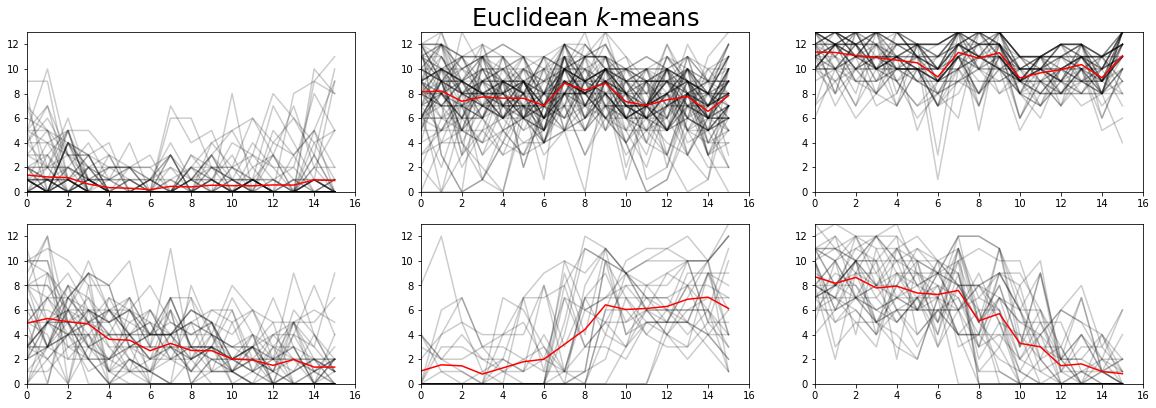

In [12]:
plt.figure(figsize=(20,10))
for yi in range(6):
    plt.subplot(3, 3, yi + 1)
    for xx in X_TS[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_TS.shape[1])
    plt.ylim(0, 13)
    if yi == 1:
        plt.title("Euclidean $k$-means", fontsize=24)


In [70]:
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=6,  metric="dtw", verbose=True, max_iter_barycenter=10, random_state=seed)
y_pred = dba_km.fit_predict(X_TS)

DBA k-means
57.022 --> 34.154 --> 33.191 --> 33.045 --> 32.998 --> 32.995 --> 32.990 --> 32.980 --> 32.948 --> 32.917 --> 32.911 --> 32.911 --> 


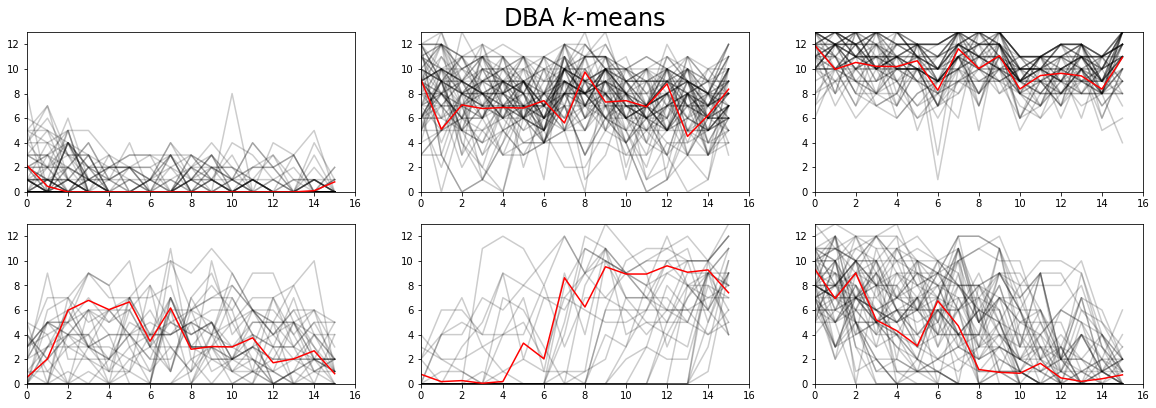

In [71]:
plt.figure(figsize=(20,10))
for yi in range(6):
    plt.subplot(3, 3, yi + 1) 
    for xx in X_TS[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_TS.shape[1])
    plt.ylim(0, 13)
    if yi == 1:
        plt.title("DBA $k$-means",fontsize=24)

In [72]:
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=6, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True, random_state=seed)
y_pred = sdtw_km.fit_predict(X_TS)


Soft-DTW k-means
4816.777 --> 1647.872 --> 1596.684 --> 1569.176 --> 1564.514 --> 1559.086 --> 1556.960 --> 1554.214 --> 1557.943 --> 1557.983 --> 1557.402 --> 1558.038 --> 1557.490 --> 1557.725 --> 1557.586 --> 1557.583 --> 1557.543 --> 1557.562 --> 1557.566 --> 1557.569 --> 1557.571 --> 1557.571 --> 1557.572 --> 1557.572 --> 1557.572 --> 1557.572 --> 1557.572 --> 


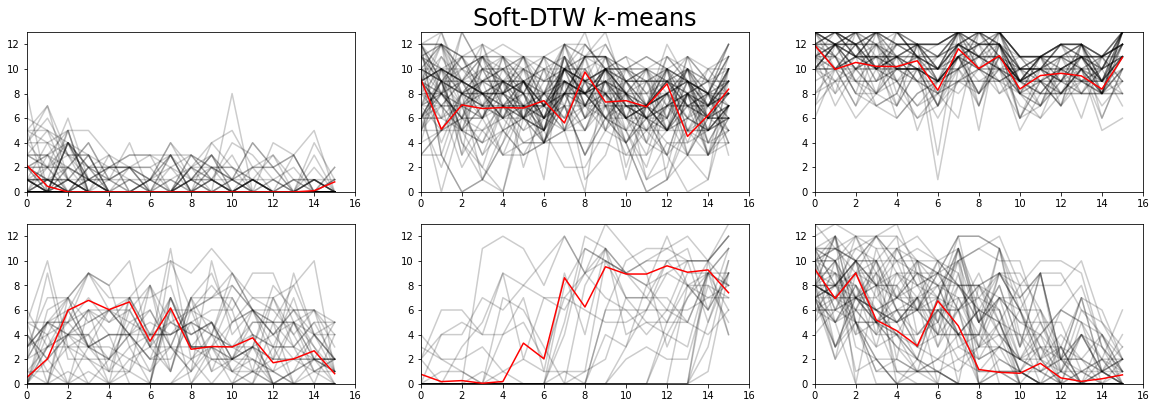

In [73]:
plt.figure(figsize=(20,10))
for yi in range(6):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_TS[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_TS.shape[1])
    plt.ylim(0, 13)
    if yi == 1:
        plt.title("Soft-DTW $k$-means",fontsize=24)

## Search for Nearest Neighbor of Selected Member

In [13]:
print('Enter Member No:')
Mem=int(input())

Enter Member No:
229


In [14]:
#r=sample(range(X_TS.shape[0]),1)
r=X.index.get_loc(Mem)

knnSearch = KNeighborsTimeSeries(n_neighbors=5, metric="dtw")
knnSearch.fit(X=X_TS, y= Y)

dists, ind = knnSearch.kneighbors(to_time_series_dataset(X_TS[[r]]))

#print("1. Nearest neighbour search")
print("Computed nearest neighbor indices (wrt DTW)\n", ind)
#print("First nearest neighbor class:", y_test[ind[:, 0]])


Computed nearest neighbor indices (wrt DTW)
 [[101   2 234 214  58]]


In [15]:
Colordict={0:'rgb(204, 0, 0)',4:'rgb(255, 51, 51)',3:'rgb(255, 102, 102)',1:'rgb(255, 128, 128)',5:'rgb(255, 153, 153)',2:'rgb(255, 204, 204)'}

Labeldict={0:'-1',1:'0',2:'1',3:'X',4:'io',5:'oi'}


In [20]:
n=5 #n nearest neighbor
trace0 = go.Scatter(
    x = np.asarray(range(16)),
    y = X_TS[r],
    mode = 'lines+markers',
    line = dict(
        color = (Colordict[Y[r]]), width=3),
    name = 'SelectedMem: ' + str(X.index[r]) +'  L: '+ Labeldict[Y[r]],
    text='SelectedMem: ' + str(X.index[r]) +'  L: '+ Labeldict[Y[r]],
    hoverinfo = 'text'
 
)

data=[trace0]

for i in range(1,n):
    trace=go.Scatter(
    x = np.asarray(range(16)),
    y = X_TS[ind[0][i]],
    mode = 'lines+markers',
    line = dict(
        color = (Colordict[Y[ind[0][i]]]),
        dash = 'dot'),
    name = 'Mem: ' + str(X.index[ind[0][i]]) +'  L: '+ Labeldict[Y[ind[0][i]]],
    text = 'Mem: ' + str(X.index[ind[0][i]]) +'  L: '+ Labeldict[Y[ind[0][i]]],
    hoverinfo = 'text'    
    )
    
    data.append(trace)

#xlabels=['Q1','Q2','Q3','Q4','Q1','Q2','Q3','Q4','Q1','Q2','Q3','Q4','Q1','Q2','Q3','Q4']
xlabels=['2015','2016','2017','2018']

init_notebook_mode(connected=True)

iplot({"data":data,
       "layout": go.Layout(title="Nearest Neighbors to Member "+ str(X.index[ind[0][0]]),
                          xaxis=go.layout.XAxis(ticktext=xlabels,tickvals=list(range(3,16,4)))
                          )})



In [34]:
#import nbformat
#nb = nbformat.read('LifeCycle_v1.ipynb', 4)
#from plotlyhtmlexporter import PlotlyHTMLExporter
#exp = PlotlyHTMLExporter()
#body, resources = exp.from_notebook_node(nb)

In [32]:
from ipywidgets import widgets


In [35]:
from IPython.display import display
text= widgets.Text()
display(text)

def handle_submit(sender):
    print(text.value)

text.on_submit(handle_submit)

Text(value='')

test
k


In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



In [38]:
from IPython.html import widgets
from IPython.display import display, clear_output
from plotly.widgets import GraphWidget

<IPython.core.display.Javascript object>

In [49]:
r

101

In [118]:
button = widgets.Button(description="Submit")

In [123]:
from IPython.display import clear_output

def isTextValid(text):
    clear_output()
    
    display(container)
    
    
    valid.value=True
    message.value = ""
    Mem1=int(text_input.value.upper())
    r=X.index.get_loc(Mem1)
    
    container.observe(isTextValid)

    g2=iplot({
    "data": [go.Scatter(x= np.asarray(range(16)), y=X_TS[r])],
    "layout": go.Layout(title="TS")
    })
    

    

    

In [124]:
g2= GraphWidget('https://plot.ly/~Lily/1004')


text_input = widgets.Text(
    description='Mem:',
    value='',
)

message = widgets.HTML(
    value="",
)

valid = widgets.Valid(
    value=True,
)

# this will be initalize our listener
button.on_click(isTextValid)


container = widgets.HBox(children=[text_input, button, valid, message])



display(container)
container.observe(isTextValid)

#display(g2)




In [125]:
from ipywidgets import interact

def f(x):
    return x

#display(interact(f, x='Hi there!'))


interactive(children=(Text(value='Hi there!', description='x'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(x)>

In [126]:
tho

ModuleNotFoundError: No module named 'nbinteract'

In [ ]:
######jupyter nbconvert --to html LifeCycle_v1.ipynb